In [ ]:
#Import statements
import warnings
import firebase_admin
from firebase_admin import credentials, firestore
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os.path
from os import path
from firebase_admin import auth

pd.set_option('display.expand_frame_repr', None)

In [ ]:
#Generates an excel file with all the data so we are not pulling everytime from the firestore
if not path.exists("excerciesDf.xlsx"):
  print("\n Extracting from firebase... \n")
  if not firebase_admin._apps:
      cred = credentials.Certificate('matematia-82ea6-firebase-adminsdk-fq7om-1e3c0370a6.json') 
      default_app = firebase_admin.initialize_app(cred)
  db = firestore.client() 
  excercisesStreamDocs = db.collection('exercises').stream()

  exercisesSkillsArray = []
  jointskillsDict = {}
  skillsDictionary = {}

  for doc in excercisesStreamDocs:
    temp = doc.to_dict()
    skillset = temp["skills"]
    text = "NA"
    if temp["text"]:
      text = temp["text"]
    else:
      for question in temp["questions"]:
        text = question["text"]
    for skill in skillset:
      skillsDictionary[skill] = True
    exercisesSkillsArray.append([doc.id, text, skillset])
  excerciesDf = pd.DataFrame(exercisesSkillsArray, columns=["Excercise UID", "Text", "Skills"])
  excerciesDf.to_excel("excerciesDf.xlsx")
  skillsDf = pd.DataFrame(list(skillsDictionary.keys()), columns = ['Skills']) 
  skillsDf.to_excel("skillsDf.xlsx")
else:
  print("\n Extracting from Excel... \n")
  skillsDf = pd.read_excel (r'skillsDf.xlsx')
  excerciesDf = pd.read_excel (r'excerciesDf.xlsx')
  skillsDf = skillsDf.drop(excerciesDf.columns[0], axis=1)
  excerciesDf = excerciesDf.drop(excerciesDf.columns[0], axis=1)
print("\n excerciesDf \n")
excerciesDf.head()


 Extracting from firebase... 


 excerciesDf 



,Excercise UID,Text,Skills
0,00KxrWRrYBtZWTG4rvGx,"Al retomar actividades la fábrica, hay ajustes...",[mathematicalThinking]
1,0LVrJmwH8sp98Y4HQ1XH,Para poder modelar un dispositivo en forma de ...,"[workingMemory, reasoning]"
2,0Q0TfhsTnt25BYwAUs9F,Un panel solar de 2 m de largo produce 300 w ...,"[reasoning, workingMemory, proceduralMemory]"
3,0VtHgJxtgo1W746KZ6bj,¿Qué significa que dos polígonos sean semejantes?,"[reasoning, semanticMemory]"
4,0kePH0LjRw2bFERdL8mh,"Para colocar un kiosko, te solicitan que calcu...",[semanticMemory]


In [ ]:
print("\n skillsDf \n")
skillsDf.head()


 skillsDf 



,Skills
0,mathematicalThinking
1,workingMemory
2,reasoning
3,proceduralMemory
4,semanticMemory


In [ ]:
if not path.exists("subtopicsDf.xlsx"):
  print("From Firebase \n")
  subtopicsCollection = db.collection('subtopics').stream()
  subtopicsArray = []
  for subtopicDoc in subtopicsCollection:
    subtopic = subtopicDoc.to_dict()
    subtopicsArray.append([subtopicDoc.id, subtopic["name"]])
  subtopicsDf = pd.DataFrame(subtopicsArray, columns=["SubtopicId", "Name"])
  subtopicsDf.to_excel("subtopicsDf.xlsx")
else:
  print("From Excel \n")
  subtopicsDf = pd.read_excel (r'subtopicsDf.xlsx')
  subtopicsDf = subtopicsDf.drop(subtopicsDf.columns[0], axis=1)
print("subtopicsDf")
subtopicsDf.head()

From Firebase 

subtopicsDf


,SubtopicId,Name
0,2ob5xE3e2aSwALMAETsx,Resolver potencias con exponente entero y apro...
1,3W2dLrezw1aLvqq6ANIY,Formular y resolver ecuaciones de la forma ax ...
2,6DyfXHeJohcx4SYSc9Z3,Leyes de los Exponentes.
3,6bokHGaIYUYF1sMwDv4Q,Usar las nociones de probabilidad y cálculo de...
4,7vKlPc58pu0ljRquJmK9,Convertir fracciones decimales en notación dec...


In [ ]:
def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot.reference for snapshot
                in coll_ref.limit(1000).order_by("beginAt").start_after(cursor).stream()]
    else:
        docs = [snapshot.reference for snapshot
                in coll_ref.limit(1000).order_by("beginAt").stream()]

    count = count + len(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].get())
    else:
        print(count)
        return count

In [ ]:

#Gets the training data from all users, asings a 0 if the answer was incorrect and a 1 if it was
if not path.exists("trainingsDf.xlsx"):
  print("From Firebase")
  trainingSize = count_collection(db.collection('training'), 0)
  usersDictionary = {}
  notFoundUsersArray = {} 

  trainingsArray = []
  #trainingCollection = db.collection('training').stream()
  trainingCollection = []
  batchSizes = 1000
  limit = trainingSize/batchSizes
  print("limit: "+str(limit))
  for i in range(0, int(limit)):
    query = None
    if i == 0:
      print("batch size: "+str(batchSizes) +" on index: "+str(i))
      query = db.collection("training").order_by("beginAt").limit(batchSizes).stream()
    else:
      if i == int(limit)-1:
        last_doc = trainingCollection[-1].to_dict()
        batchSize = batchSizes+(trainingSize%batchSizes)
        print("batch size: "+str(batchSize) +" on index: "+str(i))
        query = db.collection("training").order_by("beginAt").limit(batchSize).start_after({u'beginAt': last_doc["beginAt"]}).stream()
      else:
        print("batch size: "+str(batchSizes) +" on index: "+str(i))
        last_doc = trainingCollection[-1].to_dict()
        query = db.collection("training").order_by("beginAt").limit(batchSizes).start_after({u'beginAt': last_doc["beginAt"]}).stream()

    trainingCollection.extend(query)
  
  print("Size downlaoded "+str(len(trainingCollection)))

  for training in trainingCollection:
    training = training.to_dict()
    try:
      if training["userId"] not in usersDictionary:
        user = auth.get_user(training["userId"])
        usersDictionary[training["userId"]] = user.email
      subtopicName = subtopicsDf.loc[subtopicsDf['SubtopicId'] == training["subtopicsId"]]["Name"].item()
      trainingsArray.append([  training["id"], training["userId"], usersDictionary[training["userId"]], training["result"], training["subtopicsId"], subtopicName, training["exercises"] ])
    except:
      if training["userId"] not in notFoundUsersArray:
        notFoundUsersArray[training["userId"]] = True

  usersNotFoundDF = pd.DataFrame(notFoundUsersArray.keys(), columns=["UserId"])
  usersNotFoundDF.to_excel("usersNotFoundDF.xlsx")
  trainingsDf = pd.DataFrame(trainingsArray, columns=["Id","UserId","User Email", "Result", "SubtopicId", "Subtopic Name", "Excercises"])
  trainingsDf.to_excel("trainingsDf.xlsx")
else:
  print("From Excel")
  trainingsDf = pd.read_excel (r'trainingsDf.xlsx')
  trainingsDf = trainingsDf.drop(trainingsDf.columns[0], axis=1)

print("\n trainingsDf \n")
print(len(trainingsDf))
trainingsDf.head()

From Firebase
10561
limit: 10.561
batch size: 1000 on index: 0
batch size: 1000 on index: 1
batch size: 1000 on index: 2
batch size: 1000 on index: 3
batch size: 1000 on index: 4
batch size: 1000 on index: 5
batch size: 1000 on index: 6
batch size: 1000 on index: 7
batch size: 1000 on index: 8
batch size: 1561 on index: 9
Size downlaoded 10561

 trainingsDf 

9037


,Id,UserId,User Email,Result,SubtopicId,Subtopic Name,Excercises
0,KNL4xaPAKuWYhuY69jfI,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,70.0,v5F5JyRyR0Fbva3GqaAq,Convertir en múltiplos y submúltiplos las unid...,"[M2cf8DzhcMeuVJNlBGwP, NkN0Aun9kKXxxxm0Y10V, f..."
1,8bjbrN1CBHKgK3uivLZU,HZfUZ6cwG2hb7qNk8zh9MgrDZsH2,saul.rosas.cecyted07@cecyte.edu.mx,30.0,yng6HoMtNoVjfLaeooro,Resolver problemas de multiplicación y divisió...,"[HYYjQyKA1fnXDDJS1LXq, LLFQpaiVgVGdedTa9zLw, O..."
2,wePFAGB4CInIdkZc5kG3,Qh2HjEFrpQf7JIRgC0As8zj93mL2,jose.monrreal.cecyted07@cecyte.edu.mx,70.0,zcaBba8tZ6cIdO9u1F98,Jerarquizar las operaciones para encontrar exp...,"[OQncsNWKqSFg06d5PoIy, gRDXM6t0nBgsAgo2eiSR, k..."
3,KrUwkcoVMSQ2PWatUz0T,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,60.0,wnevNAT0FY3KTq9UQTV1,Calcular el volumen de prismas cuya base sea u...,"[9yzwGYGweXzc4YbTCWZk, SkmB7QLI8GYmuiabfErR, T..."
4,bzE9Pyffy7I3GULduriI,Qh2HjEFrpQf7JIRgC0As8zj93mL2,jose.monrreal.cecyted07@cecyte.edu.mx,70.0,2ob5xE3e2aSwALMAETsx,Resolver potencias con exponente entero y apro...,"[1ujUdjIMapHnrOrEoDCz, 4i0PwIHRvnkLuDEYi7NR, I..."


In [ ]:

trainingsDf = trainingsDf.drop_duplicates(subset=["UserId", "SubtopicId"])
print("\n no duplicates \n")
print(len(trainingsDf))
trainingsDf.to_excel("na_trainingsDf.xlsx")

trainingsDf.head()


 no duplicates 

2989


,Id,UserId,User Email,Result,SubtopicId,Subtopic Name,Excercises
0,KNL4xaPAKuWYhuY69jfI,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,70.0,v5F5JyRyR0Fbva3GqaAq,Convertir en múltiplos y submúltiplos las unid...,"[M2cf8DzhcMeuVJNlBGwP, NkN0Aun9kKXxxxm0Y10V, f..."
1,8bjbrN1CBHKgK3uivLZU,HZfUZ6cwG2hb7qNk8zh9MgrDZsH2,saul.rosas.cecyted07@cecyte.edu.mx,30.0,yng6HoMtNoVjfLaeooro,Resolver problemas de multiplicación y divisió...,"[HYYjQyKA1fnXDDJS1LXq, LLFQpaiVgVGdedTa9zLw, O..."
2,wePFAGB4CInIdkZc5kG3,Qh2HjEFrpQf7JIRgC0As8zj93mL2,jose.monrreal.cecyted07@cecyte.edu.mx,70.0,zcaBba8tZ6cIdO9u1F98,Jerarquizar las operaciones para encontrar exp...,"[OQncsNWKqSFg06d5PoIy, gRDXM6t0nBgsAgo2eiSR, k..."
3,KrUwkcoVMSQ2PWatUz0T,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,60.0,wnevNAT0FY3KTq9UQTV1,Calcular el volumen de prismas cuya base sea u...,"[9yzwGYGweXzc4YbTCWZk, SkmB7QLI8GYmuiabfErR, T..."
4,bzE9Pyffy7I3GULduriI,Qh2HjEFrpQf7JIRgC0As8zj93mL2,jose.monrreal.cecyted07@cecyte.edu.mx,70.0,2ob5xE3e2aSwALMAETsx,Resolver potencias con exponente entero y apro...,"[1ujUdjIMapHnrOrEoDCz, 4i0PwIHRvnkLuDEYi7NR, I..."


In [ ]:
user_indices = pd.DataFrame(list(set(trainingsDf['UserId'].unique())),columns=['UserId'])
user_indices['user_index']=user_indices.index
print(len(user_indices))
user_indices.head()

445


,UserId,user_index
0,1WYVmjIYLFZEeEieEIuLTMLaZdl1,0
1,akYRI1kDkcazNjzaNjtrPgxnJ0t2,1
2,zxQZm8M1KBVO1WVkG4HVibBFyaC3,2
3,TXcjc8Fn5fdvSCF1nyuEkvvIeLZ2,3
4,7c90MVMW7gbYFN4uPeCgkM9TGig2,4


In [ ]:
item_indices = pd.DataFrame(sorted(list(set(trainingsDf['SubtopicId'].unique()))),columns=['SubtopicId'])
item_indices['subtopic_index']=item_indices.index
subtopicsDf = pd.merge(subtopicsDf , item_indices,on='SubtopicId')

print(len(item_indices))
item_indices.head()

45


,SubtopicId,subtopic_index
0,2ob5xE3e2aSwALMAETsx,0
1,3W2dLrezw1aLvqq6ANIY,1
2,6DyfXHeJohcx4SYSc9Z3,2
3,6bokHGaIYUYF1sMwDv4Q,3
4,7vKlPc58pu0ljRquJmK9,4


In [ ]:
trainingsDf = pd.merge(trainingsDf , item_indices,on='SubtopicId')
#join the user indices
trainingsDf = pd.merge(trainingsDf, user_indices,on='UserId')
#inspec the data frame
trainingsDf.head()

,Id,UserId,User Email,Result,SubtopicId,Subtopic Name,Excercises,subtopic_index,user_index
0,KNL4xaPAKuWYhuY69jfI,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,70.000000,v5F5JyRyR0Fbva3GqaAq,Convertir en múltiplos y submúltiplos las unid...,"[M2cf8DzhcMeuVJNlBGwP, NkN0Aun9kKXxxxm0Y10V, f...",40,195
1,5DugaABEQ57G7JvF620P,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,37.500000,yng6HoMtNoVjfLaeooro,Resolver problemas de multiplicación y divisió...,"[HYYjQyKA1fnXDDJS1LXq, LLFQpaiVgVGdedTa9zLw, O...",43,195
2,KrUwkcoVMSQ2PWatUz0T,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,60.000000,wnevNAT0FY3KTq9UQTV1,Calcular el volumen de prismas cuya base sea u...,"[9yzwGYGweXzc4YbTCWZk, SkmB7QLI8GYmuiabfErR, T...",41,195
3,vvBR7xUGnBoDpQUMlYT8,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,100.000000,rPThbHCB5qc3xFzUvydG,Usar criterios de divisibilidad e identiﬁcar l...,"[14vppOosCvUeUEUm1ELn, zN9XilULAd57quREaUem, v...",38,195
4,QYxTK0ixuXv6DZUpwuT3,P1994oxT4CTRqOYrQUZgjBADTVT2,heber.valenzuela.cecyted09@cecyte.edu.mx,77.777778,7vKlPc58pu0ljRquJmK9,Convertir fracciones decimales en notación dec...,"[h6AI0FBxX5ipf8mMiU9w, KDbn0RSWfns2DRw8mFeV, E...",4,195


In [ ]:
subtopic_wide = trainingsDf.pivot(index = 'subtopic_index', columns = 'user_index', values = 'Result').fillna(0)
subtopic_wide.head()

user_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444
subtopic_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,80.000000,20.000000,0.0,0.000000,0.0,0.0,0.0,30.0,0.000000,0.0,0.0,70.000000,0.0,0.000000,0.000000,0.0,50.000000,80.000000,0.0,0.000000,0.0,0.0,30.0,0.0,20.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,50.000000,0.000000,...,0.0,0.0,0.0,20.000000,60.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,90.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,80.0,10.000000,20.000000,0.0,0.0,0.0,0.0,0.0,40.000000,70.0,0.0,70.000000,0.0,0.000000,0.0,0.0,0.0,0.0,70.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,66.666667,0.000000,0.0,55.555556,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,44.444444,0.000000,77.777778,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,77.777778,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,90.000000,0.000000,0.0,80.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,80.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,80.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.333333,0.000000,0.0,33.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,44.444444,0.0,44.444444,0.000000,0.0,11.111111,55.555556,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,44.444444,0.000000,...,0.0,0.0,0.0,0.000000,33.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,88.888889,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,55.555556,0.0,0.0,0.0,0.0,0.0,33.333333,0.0,0.0,66.666667,0.0,0.000000,0.0,0.0,0.0,0.0,44.444444,0.0
4,60.0,60.0,30.0,40.0,0.0,80.0,70.0,88.888889,44.444444,60.0,70.000000,80.0,0.0,0.0,50.0,66.666667,0.0,50.0,40.000000,60.0,0.000000,77.777778,0.0,70.000000,40.000000,70.0,11.111111,70.0,60.0,0.0,40.0,60.0,66.666667,0.000000,77.777778,80.000000,70.0,40.0,50.000000,44.444444,...,10.0,20.0,60.0,66.666667,40.000000,50.0,50.0,90.0,0.0,90.0,81.818182,20.0,80.000000,70.0,70.0,44.444444,40.0,30.0,0.0,30.0,80.0,22.222222,88.888889,70.0,50.0,70.0,20.0,0.0,80.000000,0.0,60.0,20.000000,40.0,11.111111,0.0,0.0,0.0,90.0,60.000000,30.0


DATA ANALYSIS AND ETL

In [ ]:
#Calculating the sparsity
no_of_users = len(trainingsDf['UserId'].unique())
no_of_subtopics = len(trainingsDf['SubtopicId'].unique())

sparsity = round(1.0 - len(trainingsDf)/(1.0*(no_of_subtopics*no_of_users)),3)
print ("Sparsity: "+str(sparsity*100)+"%")

Sparsity: 85.1%


In [ ]:
avg_subtopic_rating = pd.DataFrame(trainingsDf.groupby('subtopic_index')['Result'].agg(['mean','count']))
avg_subtopic_rating['subtopic_index'] = avg_subtopic_rating.index
avg_subtopic_rating.head()

,mean,count,subtopic_index
subtopic_index,,,
0,52.293578,109,0
1,50.574713,29,1
2,73.809524,21,2
3,41.856925,73,3
4,55.341880,338,4


In [ ]:
#calculate the percentile count. It gives the no of ratings at least 70% of the subtopics have
np.percentile(avg_subtopic_rating['count'],70)

67.6

In [ ]:
import tensorflow.keras as tf
from sklearn.model_selection import train_test_split
ratings_df = trainingsDf[["subtopic_index", "user_index", "Result"]]
ratings_df.head()

,subtopic_index,user_index,Result
0,40,195,70.000000
1,43,195,37.500000
2,41,195,60.000000
3,38,195,100.000000
4,4,195,77.777778


In [ ]:

Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (2391, 3)
Shape of test data: (598, 3)


In [ ]:

#Get the number of unique entities in subtopics and users columns
nsubtopic_id = ratings_df.subtopic_index.nunique()
nuser_id = ratings_df.user_index.nunique()


#subtopic input network
input_subtopics = tf.layers.Input(shape=[1])
embed_subtopics = tf.layers.Embedding(nsubtopic_id + 1,15)(input_subtopics)
subtopics_out = tf.layers.Flatten()(embed_subtopics)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([subtopics_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)

model = tf.Model([input_subtopics, input_users], x_out)

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        690         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        6690        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
hist = model.fit([Xtrain.subtopic_index, Xtrain.user_index], Xtrain.Result, 
                 batch_size=32, 
                 epochs=40, 
                 verbose=1,
                 validation_data=([Xtest.subtopic_index, Xtest.user_index], Xtest.Result))


Epoch 1/40
75/75 [==============================] - 1s 4ms/step - loss: 3530.9277 - val_loss: 3403.9888
Epoch 2/40
75/75 [==============================] - 0s 2ms/step - loss: 2670.4204 - val_loss: 1815.0815
Epoch 3/40
75/75 [==============================] - 0s 2ms/step - loss: 1024.9899 - val_loss: 606.9191
Epoch 4/40
75/75 [==============================] - 0s 2ms/step - loss: 508.0817 - val_loss: 490.5740
Epoch 5/40
75/75 [==============================] - 0s 2ms/step - loss: 420.9496 - val_loss: 458.7345
Epoch 6/40
75/75 [==============================] - 0s 2ms/step - loss: 376.8406 - val_loss: 449.5159
Epoch 7/40
75/75 [==============================] - 0s 2ms/step - loss: 353.3979 - val_loss: 448.3845
Epoch 8/40
75/75 [==============================] - 0s 2ms/step - loss: 337.1939 - val_loss: 450.0450
Epoch 9/40
75/75 [==============================] - 0s 2ms/step - loss: 327.7388 - val_loss: 452.9074
Epoch 10/40
75/75 [==============================] - 0s 2ms/step - loss: 321.

In [ ]:
hist.history


{'loss': [3530.927734375,
  2670.42041015625,
  1024.9898681640625,
  508.08172607421875,
  420.9496154785156,
  376.84063720703125,
  353.3978576660156,
  337.1939392089844,
  327.7388000488281,
  321.053466796875,
  316.7222900390625,
  313.8570861816406,
  311.8621520996094,
  310.7985534667969,
  309.56414794921875,
  308.7362365722656,
  308.3377685546875,
  307.7271423339844,
  306.31195068359375,
  307.0531921386719,
  306.7577819824219,
  306.7209167480469,
  306.2936096191406,
  305.7355041503906,
  305.5542907714844,
  306.1808166503906,
  304.99920654296875,
  307.55877685546875,
  305.645751953125,
  305.7922668457031,
  305.7122497558594,
  305.8273620605469,
  305.0184326171875,
  305.8511657714844,
  305.8465881347656,
  304.999755859375,
  305.274658203125,
  305.14398193359375,
  305.1334533691406,
  304.6653137207031],
 'val_loss': [3403.98876953125,
  1815.08154296875,
  606.9191284179688,
  490.5740051269531,
  458.7345275878906,
  449.5158996582031,
  448.384521484

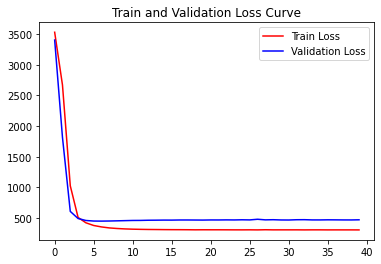

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
import matplotlib.pyplot as plt

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.savefig("loss.png")
plt.show()

In [ ]:
model.save('model')


INFO:tensorflow:Assets written to: model/assets


In [ ]:
# Extract embeddings
subtopic_em = model.get_layer('embedding_1')
subtopic_em_weights = subtopic_em.get_weights()[0]

In [ ]:
subtopic_em_weights.shape


(446, 15)

In [ ]:

subtopic_df_copy = subtopicsDf.copy()
subtopic_df_copy = subtopic_df_copy.set_index("subtopic_index")
subtopic_df_copy.head()

,SubtopicId,Name
subtopic_index,,
0,2ob5xE3e2aSwALMAETsx,Resolver potencias con exponente entero y apro...
1,3W2dLrezw1aLvqq6ANIY,Formular y resolver ecuaciones de la forma ax ...
2,6DyfXHeJohcx4SYSc9Z3,Leyes de los Exponentes.
3,6bokHGaIYUYF1sMwDv4Q,Usar las nociones de probabilidad y cálculo de...
4,7vKlPc58pu0ljRquJmK9,Convertir fracciones decimales en notación dec...


In [ ]:

b_id =list(ratings_df.subtopic_index.unique())
b_id

[40,
 43,
 41,
 38,
 4,
 37,
 26,
 18,
 14,
 6,
 20,
 15,
 13,
 9,
 3,
 16,
 1,
 29,
 22,
 36,
 35,
 25,
 42,
 17,
 7,
 34,
 24,
 19,
 10,
 11,
 21,
 23,
 8,
 28,
 32,
 2,
 27,
 0,
 12,
 5,
 31,
 33,
 44,
 39,
 30]

In [ ]:
dict_map = {}
for i in b_id:
    dict_map[i] = subtopic_df_copy.iloc[i]['Name']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')

for i in b_id:
    subtopic = dict_map[i]
    embeddings = subtopic_em_weights[i]
    out_m.write(subtopic + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [ ]:
subtopic_arr = np.array(b_id)
user_no = 22
subtopic_arr

array([40, 43, 41, 38,  4, 37, 26, 18, 14,  6, 20, 15, 13,  9,  3, 16,  1,
       29, 22, 36, 35, 25, 42, 17,  7, 34, 24, 19, 10, 11, 21, 23,  8, 28,
       32,  2, 27,  0, 12,  5, 31, 33, 44, 39, 30])

In [ ]:
subtopic_arr = np.array(b_id)
user_no = 22
user = np.array([user_no for i in range(len(b_id))])
arr = [subtopic_arr, user]
arr

[array([40, 43, 41, 38,  4, 37, 26, 18, 14,  6, 20, 15, 13,  9,  3, 16,  1,
        29, 22, 36, 35, 25, 42, 17,  7, 34, 24, 19, 10, 11, 21, 23,  8, 28,
        32,  2, 27,  0, 12,  5, 31, 33, 44, 39, 30]),
 array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22])]

In [ ]:
#MAKING PREDICTIONS

pred = model.predict([subtopic_arr, user])
pred

array([[34.269955  ],
       [23.481125  ],
       [39.153378  ],
       [44.210423  ],
       [50.48744   ],
       [45.479362  ],
       [22.200417  ],
       [ 0.18386051],
       [40.761112  ],
       [24.844685  ],
       [38.204205  ],
       [21.725876  ],
       [39.344803  ],
       [33.63879   ],
       [20.86193   ],
       [37.970318  ],
       [19.70196   ],
       [25.92967   ],
       [29.253613  ],
       [34.881042  ],
       [38.02741   ],
       [25.50995   ],
       [34.87953   ],
       [41.049664  ],
       [43.459614  ],
       [32.94974   ],
       [22.000034  ],
       [34.567654  ],
       [35.3755    ],
       [18.932335  ],
       [30.623863  ],
       [10.2982025 ],
       [13.778294  ],
       [24.492302  ],
       [20.117653  ],
       [37.992844  ],
       [36.86525   ],
       [34.26453   ],
       [30.66304   ],
       [21.670494  ],
       [20.032143  ],
       [34.27189   ],
       [38.26704   ],
       [51.951584  ],
       [36.061497  ]], dtype=flo

In [ ]:

pred = pred.reshape(-1)
pred


array([34.269955  , 23.481125  , 39.153378  , 44.210423  , 50.48744   ,
       45.479362  , 22.200417  ,  0.18386051, 40.761112  , 24.844685  ,
       38.204205  , 21.725876  , 39.344803  , 33.63879   , 20.86193   ,
       37.970318  , 19.70196   , 25.92967   , 29.253613  , 34.881042  ,
       38.02741   , 25.50995   , 34.87953   , 41.049664  , 43.459614  ,
       32.94974   , 22.000034  , 34.567654  , 35.3755    , 18.932335  ,
       30.623863  , 10.2982025 , 13.778294  , 24.492302  , 20.117653  ,
       37.992844  , 36.86525   , 34.26453   , 30.66304   , 21.670494  ,
       20.032143  , 34.27189   , 38.26704   , 51.951584  , 36.061497  ],
      dtype=float32)

In [ ]:
pred_ids = (-pred)
pred_ids

array([-34.269955  , -23.481125  , -39.153378  , -44.210423  ,
       -50.48744   , -45.479362  , -22.200417  ,  -0.18386051,
       -40.761112  , -24.844685  , -38.204205  , -21.725876  ,
       -39.344803  , -33.63879   , -20.86193   , -37.970318  ,
       -19.70196   , -25.92967   , -29.253613  , -34.881042  ,
       -38.02741   , -25.50995   , -34.87953   , -41.049664  ,
       -43.459614  , -32.94974   , -22.000034  , -34.567654  ,
       -35.3755    , -18.932335  , -30.623863  , -10.2982025 ,
       -13.778294  , -24.492302  , -20.117653  , -37.992844  ,
       -36.86525   , -34.26453   , -30.66304   , -21.670494  ,
       -20.032143  , -34.27189   , -38.26704   , -51.951584  ,
       -36.061497  ], dtype=float32)

In [ ]:
pred_ids = pred_ids.argsort()

In [ ]:
pred_ids[28]

17

In [ ]:
ratings_df.user_index.nunique()


445

In [ ]:
subtopicsDf.iloc[pred_ids]

,SubtopicId,Name,subtopic_index
43,yng6HoMtNoVjfLaeooro,Resolver problemas de multiplicación y divisió...,43
4,7vKlPc58pu0ljRquJmK9,Convertir fracciones decimales en notación dec...,4
5,9Yqj32SUJFjX0SR6PRFF,Resolver situaciones que impliquen la ubicació...,5
3,6bokHGaIYUYF1sMwDv4Q,Usar las nociones de probabilidad y cálculo de...,3
24,bEhG3aXsIG7KZlBCxB1R,Mínimo Común Múltiplo.,24
23,awakwqPNL4NCblJT34Sq,Formular y resolver sistemas de dos ecuaciones...,23
8,EaS9OXs5qut8bEct1SG3,Formular y resolver ecuaciones cuadráticas de ...,8
12,M28469UiDSZjHZH9RtOe,Series Aritméticas.,12
2,6DyfXHeJohcx4SYSc9Z3,Leyes de los Exponentes.,2
42,y9BpNrmBZY7U9D5nCWkE,Calcular el perímetro y área de polígonos regu...,42


In [ ]:
web_subtopic_data = subtopicsDf.sort_values('subtopic_index')


In [ ]:
web_subtopic_data

,SubtopicId,Name,subtopic_index
0,2ob5xE3e2aSwALMAETsx,Resolver potencias con exponente entero y apro...,0
1,3W2dLrezw1aLvqq6ANIY,Formular y resolver ecuaciones de la forma ax ...,1
2,6DyfXHeJohcx4SYSc9Z3,Leyes de los Exponentes.,2
3,6bokHGaIYUYF1sMwDv4Q,Usar las nociones de probabilidad y cálculo de...,3
4,7vKlPc58pu0ljRquJmK9,Convertir fracciones decimales en notación dec...,4
5,9Yqj32SUJFjX0SR6PRFF,Resolver situaciones que impliquen la ubicació...,5
6,An5mvHXSJhP0lCyUfWxD,Resolver problemas de reparto proporcional.,6
7,EW7OrlIz3GII3fyZqfIr,Formular expresiones algebraicas de primero y ...,7
8,EaS9OXs5qut8bEct1SG3,Formular y resolver ecuaciones cuadráticas de ...,8
9,EfrPXC4qLETnm36EDGMP,Calcular el volumen de prismas y cilindros rec...,9


In [ ]:
web_subtopic_data.to_json(r'web_subtopic_data.json', orient='records')